# Prediction Foot Project
Lorrain MORLET - Julien DE VOS


## Introduction

To introduce the prediction soccer contest, we aim to develop an AI model that can predict the outcome of soccer matches. The goal is to analyze historical data and identify patterns that can help us make accurate predictions.

The final objective of the project is to predict the outcome of Ligue 1 matches for the 2023-2024 season. To do this, we have access to data on Ligue 1 matches from the 2012-2013 season to the 2022-2023 season.

In this test, we will use some dataset containing information about various soccer matches, including team statistics, player performance, player appearance. Our objective is to train a machine learning model that can classify the result of a match as a win, loss, or draw.

By leveraging advanced algorithms and techniques, we can build a robust AI model that takes into account various factors such as team form, player stats, home advantage, and previous head-to-head records. This model will enable us to make informed predictions and gain valuable insights into the dynamics of soccer matches.

Let's dive into the exciting world of soccer matches prediction and unleash the power of AI in the realm of sports analytics!

## Imports

In [26]:
# all the necessary imports for the project

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt

import warnings

## Data Exploration

The first thing we do is importing the file `matchs_2013_2022.csv`, which contains the list of all the Ligue 1 matchs from 2012-2013 season to 2022-2023 season, with the results.

In [27]:
data = pd.read_csv("./data/matchs_2013_2022.csv")
data.head()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,Stade Geoffroy-Guichard,31952.0,Antony Gautier,4-3-3 Attacking,4-2-3-1,AS Saint-Étienne,SC Bastia,2:2,domestic_league,0
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,Parc des Sports d’Annecy,8620.0,Philippe Kalt,4-4-2 double 6,4-4-2 double 6,Thonon Évian Grand Genève FC,EA Guingamp,1:2,domestic_league,-1
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,Stade du Hainaut,14874.0,Bartolomeu Varela,4-4-2 double 6,4-3-1-2,Valenciennes FC,Lille Olympique Sporting Club Lille Métropole,0:1,domestic_league,-1
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,Roazhon Park,13391.0,Benoît Millot,4-3-3 Attacking,4-2-3-1,Stade Rennais Football Club,Thonon Évian Grand Genève FC,0:0,domestic_league,0
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,Stade François-Coty,5981.0,Benoît Bastien,4-1-4-1,4-3-3 Defending,AC Ajaccio,Stade Rennais Football Club,3:1,domestic_league,1


## Feature Engineering

Given that the aim of the model is to predict results for the 2023-2024 season on the basis of previous seasons. To estimate the effectiveness of our model, we will make predictions for the 2022-2023 season by training it on all the previous seasons.

In [28]:
features = ["attendance"] # List of features we will keep for the training
limit_date = '2022-08-05' # 2022-08-05 is the date of the first match of the 2022-2023 season

The first feature we will add is the win percentage of each team depending on whether they are playing at home or away.

In [29]:
def get_club_win_percentage(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        # Home club win percentage at home
        home_club_id = row['home_club_id']
        matches_won_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
        
        # Update the row
        data.at[index, 'home_club_win_percentage'] = ratio

        # Away club win percentage away from home
        away_club_id = row['away_club_id']
        matches_won_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)].shape[0]
        
        ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

        # Update the row
        data.at[index, 'away_club_win_percentage'] = ratio

In [30]:
get_club_win_percentage(data, limit_date)

features.append('home_club_win_percentage')
features.append('away_club_win_percentage')

The next feature we will add is the win percentage of the manager of each team depending on whether they are playing at home or away.

In [31]:
def get_win_percentage_of_manager(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        # Home club manager win percentage at home
        home_club_manager_name = row['home_club_manager_name']
        matches_won_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
        
        # Update the row
        data.at[index, 'home_club_manager_win_percentage'] = ratio

        # Away club manager win percentage away from home
        away_club_manager_name = row['away_club_manager_name']
        matches_won_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_away / total_matches_away if total_matches_away != 0 else np.nan

        # Update the row
        data.at[index, 'away_club_manager_win_percentage'] = ratio

In [32]:
get_win_percentage_of_manager(data, limit_date)

features.append('home_club_manager_win_percentage')
features.append('away_club_manager_win_percentage')

Now, we will add the win percentage of the club when they play a match with this referee

In [33]:
def get_club_win_percentage_with_referee(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        home_club_name = row['home_club_name']
        away_club_name = row['away_club_name']
        referee = row['referee']

        # Home club win percentage with this referee (at home or away)
        matches_won_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        matches_won_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan

        # Update the row
        data.at[index, 'home_club_win_percentage_with_referee'] = ratio

        # Away club win percentage with this referee (at home or away)
        matches_won_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        matches_won_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else np.nan
        
        # Update the row
        data.at[index, 'away_club_win_percentage_with_referee'] = ratio

In [34]:
get_club_win_percentage_with_referee(data, limit_date)

features.append('home_club_win_percentage_with_referee')
features.append('away_club_win_percentage_with_referee')

In [35]:
# These variables are used as global variables to avoid reading the same file multiple times
playerValuation = None
teamComps = None

def concatLists(liste:list[list[list]]) -> list[list]:
    return list(set([item for sublist in liste for item in sublist]))

def get_score_player(id:int, limit_date:str) -> float:
    global playerValuation
    playerValuation = pd.read_csv("data\player_valuation_before_season.csv", sep=",") if playerValuation is None else playerValuation
    player = playerValuation[(playerValuation["player_id"] == id) & (playerValuation["date"] < limit_date)]["market_value_in_eur"].apply(lambda x: x/1e6) 
    return player.mean() if len(player) > 0 else 0

def get_score_team(team:int, limit_date:str) -> list:
    global teamComps
    if(teamComps is None):
        lineups = pd.read_csv("data\game_lineups.csv", sep=",")
        teamComps = lineups.groupby(['club_id'])['player_id'].apply(list).reset_index()
        # print(teamComps)
        teamComps = teamComps.groupby(['club_id'])['player_id'].apply(list).apply(concatLists).reset_index()
        teamComps["score"] = teamComps["player_id"].apply(lambda x: sum([get_score_player(i, limit_date) for i in x]))
        
    return teamComps[teamComps["club_id"] == team]["score"].values[0]

def add_club_scores(X:pd.DataFrame, limit_date:str) -> None:   
    X["score_away_team"] = X["away_club_id"].apply(lambda team: get_score_team(team, limit_date))
    X["score_home_team"] = X["home_club_id"].apply(lambda team: get_score_team(team, limit_date))


In [36]:
add_club_scores(data, limit_date)

features.append('score_away_team')
features.append('score_home_team')

C:\Users\julie\AppData\Local\Temp\ipykernel_19352\2966193760.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lineups = pd.read_csv("data\game_lineups.csv", sep=",")


In [37]:
# We use a global variable to avoid reading the same file multiple times
dataTeams = None

def convert_string_to_thousands(s)->float:
    # Remove the ? sign
    # get the sign of the value
    sign = 1 if s[0] != '-' else -1
    s = s.replace('-', '').replace('+', '')
    s = s[1:] if s[0] not in "1234567890" else s
    # print("process :", s)
    value = float(s[:-1] if len(s) > 1 else 0)
    multiplier = {'k': 1, 'm': 1000}.get(s[-1:], 1)
    # Return the numeric value multiplied by the multiplier
    return value * multiplier * sign

def add_price_players(data:pd.DataFrame)->None:
    global dataTeams
    if(dataTeams is None):
        dataTeams = pd.read_csv("data\clubs_fr.csv", sep=",")
        
    dataTeams["transfer_num"] = dataTeams["net_transfer_record"].apply(convert_string_to_thousands)
    
    dataTemp = data.merge(dataTeams[['club_id', 'transfer_num']],
                                    left_on='home_club_id',
                                    right_on='club_id',
                                    how='left')#.rename(columns={'transfer_num': 'transfer_home_team'})
    data["transfer_home_team"] = dataTemp["transfer_num"]
    dataTemp = data.merge(dataTeams[['club_id', 'transfer_num']],
                                    left_on='away_club_id',
                                    right_on='club_id',
                                    how='left')#.rename(columns={'transfer_num': 'transfer_away_team'})
    data["transfer_away_team"] = dataTemp["transfer_num"]

In [38]:
add_price_players(data)

features.append('transfer_home_team')
features.append('transfer_away_team')

In [39]:
teams_stats_updated = {}
stats_players = None
playerAppearances = None

def get_stats_all_players():
    global playerAppearances
    if(playerAppearances is None):
        playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
    
    player_stats = playerAppearances.groupby('player_id').agg({
        'goals': ['mean', 'sum'],
        'assists': ['mean', 'sum'],
        'minutes_played': 'mean',
        'yellow_cards': ['mean', 'sum'],
        'red_cards': ['mean', 'sum'],
        'appearance_id': 'count'
    }).rename(columns={
        'goals': 'avg_goals_per_game total_goals',
        'assists': 'avg_assists_per_game total_assists',
        'minutes_played': 'avg_minutes_played_per_game',
        'yellow_cards': 'avg_yellow_cards_per_game total_yellow_cards',
        'red_cards': 'avg_red_cards_per_game total_red_cards',
        'appearance_id': 'total_games'
    })
    
    player_stats.columns = [col[0] for col in player_stats.columns.to_flat_index()]
    
    column_parts = [col.split() for col in player_stats.columns]
    new_column_names = []
    for i, parts in enumerate(column_parts):
        if (i > 0 and parts[0] == column_parts[i-1][0]):
            new_column_names.append(parts[1] if (len(parts) > 1) else parts[0])
        else:
            new_column_names.append(parts[0])
    player_stats.columns = new_column_names
    
    return player_stats

def get_list_players(team_id, limit_date:str = None):
    global playerAppearances
    if(playerAppearances is None):
        playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
    playerAppearances['date'] = pd.to_datetime(playerAppearances['date'])
    
    players_ids = playerAppearances[(playerAppearances["player_current_club_id"] == team_id) & (playerAppearances['date'] < limit_date)]["player_id"] 
    players_ids = players_ids.drop_duplicates()
    return list(players_ids)

def get_players_team_stats(team_id:str, limit_date:str):
    global stats_players
    if(stats_players is None):
        stats_players = get_stats_all_players()
    
    players_ids = get_list_players(team_id, limit_date)
    # print(f'players_ids : {players_ids}')
    return stats_players[stats_players.index.isin(players_ids)]

def exp_log_fn(x, num_games):
        return np.exp(x * np.log(num_games)) * 100

def get_players_team_stats_updated(team_id:str, limit_date:str):
    global teams_stats_updated
    if(team_id in teams_stats_updated):
        return teams_stats_updated[team_id]
    stats_players = get_players_team_stats(team_id, limit_date)
    
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    updated_columns = [f"{col}_updated" for col in columns]
    stats_players[[f"{col}_updated" for col in columns]] = stats_players[columns].apply(exp_log_fn, args = (stats_players["total_games"], ))
    stats_players.drop(columns=["avg_minutes_played_per_game"])
    teams_stats_updated[team_id] = stats_players
    return stats_players

def get_updated_stats_players_team_mean(team_id:str, limit_date:str):
    stats_players = get_players_team_stats_updated(team_id, limit_date)
    # print(stats_players)
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    # print(stats_players.columns)
    return stats_players[[f"{col}_updated" for col in columns]].mean() 

def add_updated_stats_players_team_mean(X:pd.DataFrame, limit_date:str):
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    X[[f"home_club_{col}_updated" for col in columns]] = X["home_club_id"].apply(lambda team: get_updated_stats_players_team_mean(team, limit_date))
    X[[f"away_club_{col}_updated" for col in columns]] = X["away_club_id"].apply(lambda team: get_updated_stats_players_team_mean(team, limit_date))
    # X["away_team_players_stats_updated"] = X["away_club_id"].apply(get_updated_stats_players_team_mean)

In [40]:
add_updated_stats_players_team_mean(data, limit_date)

for club in ["home_club", "away_club"]:
    features.append(f'{club}_avg_goals_per_game_updated')
    features.append(f'{club}_avg_assists_per_game_updated')
    features.append(f'{club}_avg_yellow_cards_per_game_updated')
    features.append(f'{club}_avg_red_cards_per_game_updated')

C:\Users\julie\AppData\Local\Temp\ipykernel_19352\2327675299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_players[[f"{col}_updated" for col in columns]] = stats_players[columns].apply(exp_log_fn, args = (stats_players["total_games"], ))
C:\Users\julie\AppData\Local\Temp\ipykernel_19352\2327675299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_players[[f"{col}_updated" for col in columns]] = stats_players[columns].apply(exp_log_fn, args = (stats_players["total_games"], ))
C:\Users\j

In [41]:
print(data.columns)
data.head()

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results',
       'home_club_win_percentage', 'away_club_win_percentage',
       'home_club_manager_win_percentage', 'away_club_manager_win_percentage',
       'home_club_win_percentage_with_referee',
       'away_club_win_percentage_with_referee', 'score_away_team',
       'score_home_team', 'transfer_home_team', 'transfer_away_team',
       'home_club_avg_goals_per_game_updated',
       'home_club_avg_assists_per_game_updated',
       'home_club_avg_yellow_cards_per_game_updated',
       'home_club_avg_red_cards_per_game_updated',
       'away_club_avg_goals_per_game_updated',
   

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,12850.0,480.0,123.579692,118.422916,161.750455,100.956715,114.952992,115.685339,145.030063,103.672756
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,0.0,3700.0,117.559406,110.052019,144.110488,101.499979,115.905138,114.907099,152.706016,100.982975
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,2520.0,3650.0,109.672593,110.773536,141.699589,103.487114,155.996558,129.430345,163.389242,101.314765
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,62100.0,0.0,145.792055,124.718132,148.306784,101.909770,117.559406,110.052019,144.110488,101.499979
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,0.0,62100.0,120.571681,113.389672,140.557162,102.557308,145.792055,124.718132,148.306784,101.909770


In [44]:
# X_train, X_test, y_train, y_test = train_test_split(data[features], data['results'], test_size=0.2, random_state=42)

In [42]:
data[features] = SimpleImputer(strategy='mean').fit_transform(data[features])
data[features] = StandardScaler().fit_transform(data[features])

data = data[features + ['date', 'results']]

X_train = data[data['date'] < limit_date]
X_test = data[data['date'] >= limit_date]
y_train = X_train['results']
y_test = X_test['results']

X_train.drop(['date', 'results'], axis=1, inplace=True)
X_test.drop(['date', 'results'], axis=1, inplace=True)

X_train.head()

C:\Users\julie\AppData\Local\Temp\ipykernel_19352\2230855971.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['date', 'results'], axis=1, inplace=True)
C:\Users\julie\AppData\Local\Temp\ipykernel_19352\2230855971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'results'], axis=1, inplace=True)


,attendance,home_club_win_percentage,away_club_win_percentage,home_club_manager_win_percentage,away_club_manager_win_percentage,home_club_win_percentage_with_referee,away_club_win_percentage_with_referee,score_away_team,score_home_team,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,0.836403,0.210477,-0.987346,0.780830,-0.937940,-0.733768,-0.130401,-0.849082,-0.240465,-0.299035,-0.535011,-0.479016,-0.378988,0.668610,-1.538798,-0.623937,-0.549985,-1.183767,2.571636
1,-1.020911,-0.751840,-0.791057,-0.350195,-0.292947,0.224573,-0.755004,-0.887748,-1.131641,-0.544110,-0.473467,-0.580169,-0.903752,-1.285621,-0.716593,-0.607916,-0.598845,-0.334002,-1.498766
2,-0.523070,-0.824290,0.663586,-1.578817,-0.125857,-0.812690,0.650352,0.078697,-1.178033,-0.496049,-0.474423,-0.712682,-0.858521,-1.552711,2.290841,0.066664,0.312963,0.848682,-0.996674
3,-0.641122,0.055677,-0.650850,-0.907145,-0.852861,0.359633,-0.755004,-1.131838,0.799738,0.640261,-0.544186,-0.105806,0.015654,-0.820737,-0.096395,-0.580081,-0.903660,-1.285568,-0.716392
4,-1.230985,-1.476335,0.215399,-1.904476,0.239523,0.548718,0.148439,0.801897,-0.987832,-0.544110,0.642739,-0.529557,-0.694517,-1.679274,0.883625,-0.105037,0.017118,-0.821018,-0.096263


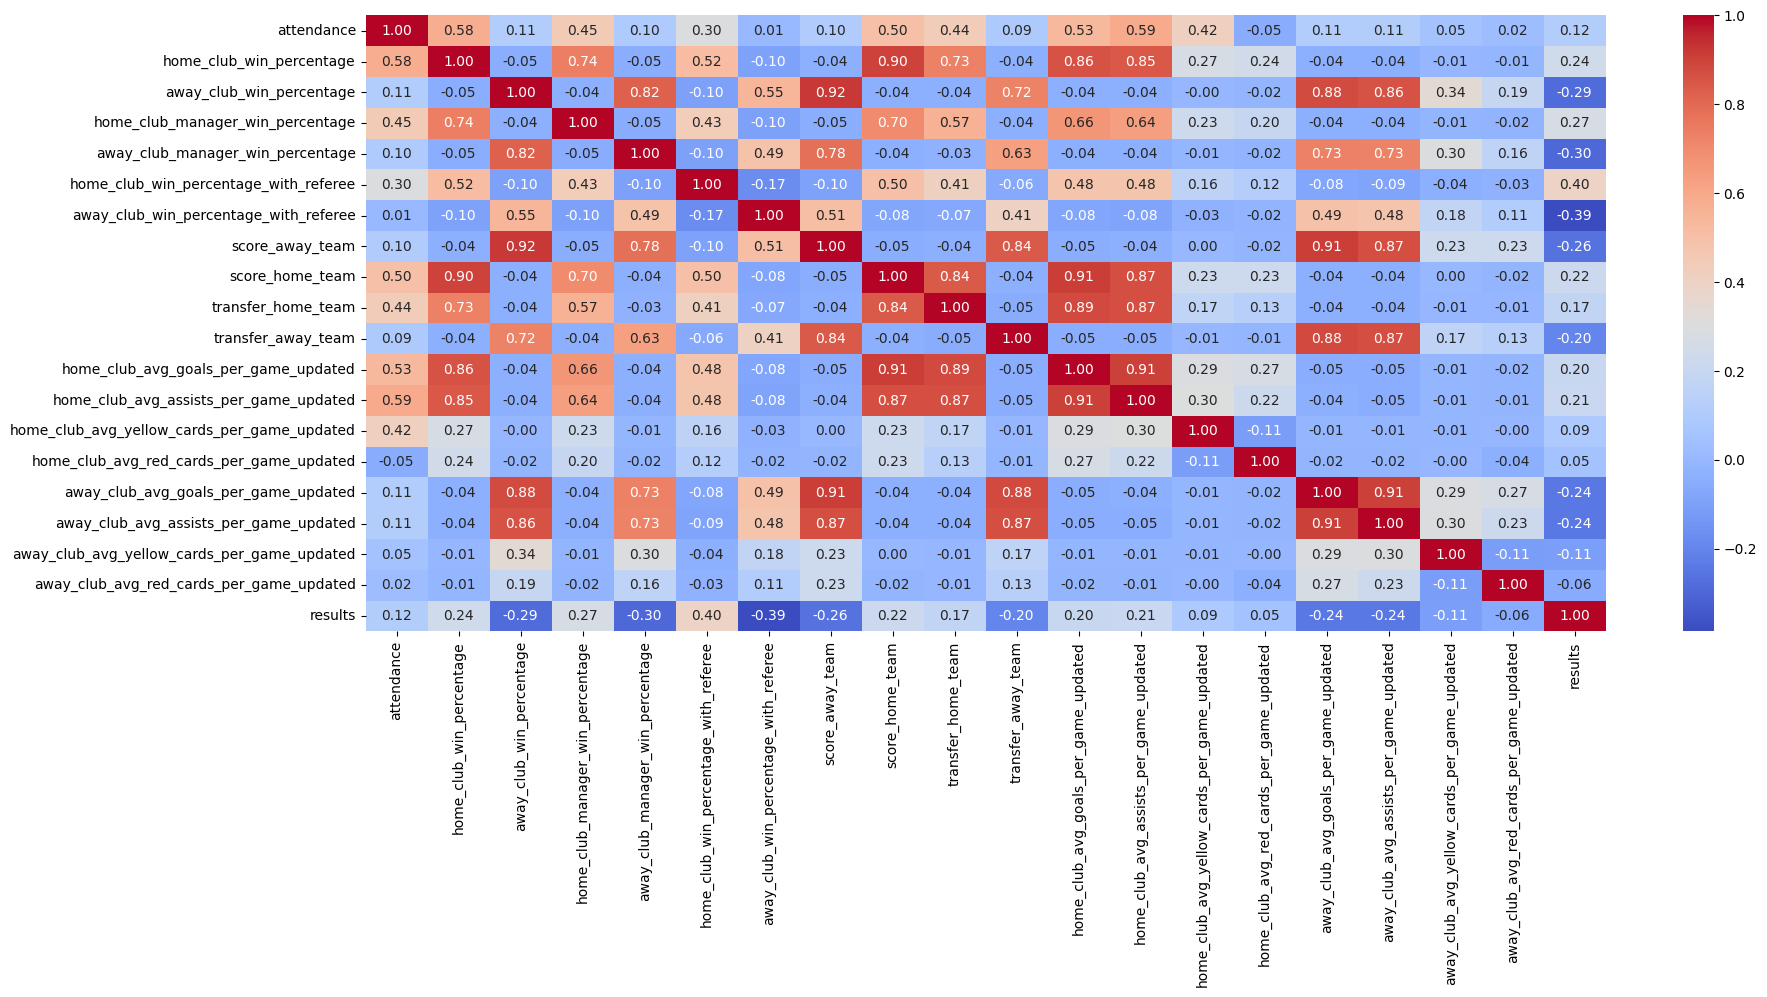

In [48]:
import seaborn as sns

def plot_correlation_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

data.drop('date', inplace=True, axis=1) if 'date' in data.columns else None

plot_correlation_matrix(data)

## Model Selection and Training

In [49]:
from fonctions_tests import test_data, test_data_before_2023, get_accuracy_with_model

# Define the names of the classifications method
names = ["LogisticRegression",
         "NBayes",
         "LDA",
         "QDA",
         "KNN",
         "SVM linear",
         "SVM rbf",
         "SVM sigmoid",
         "RandomForest",
         "DecisionTree"]

# Define the classifiers
classifiers = [LogisticRegression(C=1e5),
               GaussianNB(),
               DA.LinearDiscriminantAnalysis(),
               DA.QuadraticDiscriminantAnalysis(),
               KNeighborsClassifier(n_neighbors=5),
               SVC(kernel='linear', C=1.0),
               SVC(kernel='rbf', gamma = 1e-4),
               SVC(kernel='sigmoid', gamma = 1e-4),
               RandomForestClassifier(),
               DecisionTreeClassifier()]

scores = []
scores_before = []

# Loop through all different classfication methods
for name, clf in zip(names, classifiers):
    
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    print("\tAccuracy with", name, ":", round(accuracy,3))

	Accuracy with LogisticRegression : 0.416
	Accuracy with NBayes : 0.437
	Accuracy with LDA : 0.426
	Accuracy with QDA : 0.455
	Accuracy with KNN : 0.405
	Accuracy with SVM linear : 0.416
	Accuracy with SVM rbf : 0.482
	Accuracy with SVM sigmoid : 0.458
	Accuracy with RandomForest : 0.397
	Accuracy with DecisionTree : 0.405


In [ ]:
X_axis = np.arange(len(names)) 
  
plt.bar(X_axis - 0.2, scores, 0.4)
  
plt.xticks(X_axis, names, rotation=45) 
plt.xlabel("models") 
plt.ylabel("accuracy") 
plt.title("Accuracy for every model") 
plt.legend()
plt.show()

We can see that the bests models are : SVM linear, Logistic regression, and LDA. Therefore, we'll try to optimize the best one : SVM Linear.

Let's now find some hyperparameters for this model ! 

In [ ]:
cv = 7
all_accuracies = {}
accuracies = []
sizes = [0.01, 0.1, 1, 10, 100]
for c in sizes:
    for i in range(cv):
        accuracy = test_data(data.iloc[np.random.choice(data.index, size=int(len(data) * 0.6), replace=False)], model=SVC(kernel='linear', C=c))
        if(c not in all_accuracies): all_accuracies[c] = []
        all_accuracies[c].append(accuracy)
        # print("\tAccuracy with ", name, " : ", round(accuracy,3))
    accuracies.append(np.mean(all_accuracies[c]))
    print('fini with c = ', c)

print("\nAccuracies : ", list(zip(sizes, accuracies)))

plt.plot(np.log10(sizes), accuracies)